In [1]:
import nltk
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import re
import numpy as np
import pandas as pd
import gensim
from gensim.matutils import sparse2full
from sklearn.feature_extraction.text import TfidfVectorizer
import catboost as cb
from catboost import utils, CatBoostClassifier, CatBoostRegressor

In [2]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

In [184]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv1D, MaxPooling1D
from keras.applications import VGG16
from keras.optimizers import Adam
import keras

In [4]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [5]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/uliakaliberda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
stop_words = stopwords.words('english')

In [8]:
rn_data = pd.read_excel('reuters_news.xlsx', sheet_name=0)

### Analysing dataset

In [9]:
im_data_train = pd.read_csv('IMDB_movies/train.csv')
im_data_test = pd.read_csv('IMDB_movies/test.csv')

In [10]:
im_data_train.iloc[10]['text']

"I'm guessing the writers have never read a book of any kind, much less a Dickens novel, and certainly not David Copperfield, and that they based their screenplay on another poorly written screenplay, possibly an adaptation of Copperfield, though just as likely anything else, from which they randomly discarded about a third of the pages and then shuffled the rest, along with some random pages from a screenplay that someone's eighth grade nephew had written for an English class, and for which he had received a failing grade. <br /><br />If the casting was a bad joke - e.g., Richards as Kramer playing Micawber - which it was, then the direction and acting were the poorly- delivered punch lines. Getting beyond Kramer as Micawber, if possible, Ham was such a complete ogre, hunch-back and all, that I was half expecting at some point to see him being pursued by an angry pitch-fork and torch wielding mob of villagers. Uriah was almost as much of a clown figure as Micawber. Mr. Murdstone evoke

In [11]:
ex_sign = 0
narr_sign = 0
ques_sign = 0
for ind in range (len(im_data_train)):
    ex_sign += im_data_train.iloc[ind]['text'].count('!')
    narr_sign += im_data_train.iloc[ind]['text'].count('.')
    ques_sign += im_data_train.iloc[ind]['text'].count('?')
    

In [12]:
ex_sign

24560

In [13]:
narr_sign

327192

In [14]:
ques_sign

16088

### Preprocessing

In [15]:
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

In [16]:
def split_sentences(data_with_text):
    all_sentences = []
    for text in data_with_text:
        splitted = nltk.tokenize.sent_tokenize(text)
        all_sentences.append(splitted)
        
    flattened = [item for sub in all_sentences for item in sub]
    return flattened

In [17]:
train_data = split_sentences(im_data_train['text'])

In [18]:
train_data[:5]

["Now, I won't deny that when I purchased this off eBay, I had high expectations.",
 'This was an incredible out-of-print work from the master of comedy that I so enjoy.',
 'However, I was soon to be disappointed.',
 'Apologies to those who enjoyed it, but I just found the Compleat Al to be very difficult to watch.',
 "I got a few smiles, sure, but the majority of the funny came from the music videos (which I've got on DVD) and the rest was basically filler."]

In [19]:
def remove_symbols(data):
    data = [re.sub('\s+', ' ', sent) for sent in data]
    data = [re.sub("\'", "", sent) for sent in data]
    return data

In [20]:
train_data = remove_symbols(train_data)

In [21]:
def create_train_data(train_data):
    text_col = []
    sym_col = []
    for elem in train_data:
        text_col.append(elem[:-1])
        sym_col.append(elem[-1])
        
    res = pd.DataFrame(columns=['Sentence','Symbol'])
    res['Sentence'] = text_col
    res['Symbol'] = sym_col
    res = res.loc[(res['Symbol']=='.') | (res['Symbol']=='!') | (res['Symbol']=='?')]
    return res

In [22]:
train = create_train_data(train_data)

In [23]:
train = train.reset_index(drop=True)

In [24]:
to_remove = np.random.choice(train[train['Symbol']=='.'].index,size=200000,replace=False)

In [25]:
train.drop(to_remove, inplace=True)

In [26]:
train['Symbol'].value_counts()

.    33486
!    16040
?    12010
Name: Symbol, dtype: int64

In [27]:
# tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = remove_stopwords(list(sent_to_words(train['Sentence'])))

In [30]:
#fitting vectorizer
vectorizer = TfidfVectorizer(stop_words = 'english')
vectorizer = vectorizer.fit(train['Sentence'])

In [31]:
vectors = vectorizer.transform(train['Sentence'])

In [159]:
svd = TruncatedSVD(n_components=300, n_iter=10, random_state=42)
svd.fit(vectors)

TruncatedSVD(n_components=300, n_iter=10, random_state=42)

In [160]:
print(svd.explained_variance_ratio_.sum())

0.27658012351176997


In [161]:
vectors_svd = svd.transform(vectors)

### Test preprocessing

In [162]:
test_data = split_sentences(im_data_test['text'])
test_data = remove_symbols(test_data)
test = create_train_data(test_data)
to_remove = np.random.choice(test[test['Symbol']=='.'].index,size=226000,replace=False)
test.drop(to_remove, inplace=True)
to_remove = np.random.choice(test[test['Symbol']=='?'].index,size=11000,replace=False)
test.drop(to_remove, inplace=True)
to_remove = np.random.choice(test[test['Symbol']=='!'].index,size=14000,replace=False)
test.drop(to_remove, inplace=True)
test_svd = vectorizer.transform(test['Sentence'])
test_svd = svd.transform(test_svd)

In [36]:
test['Symbol'].value_counts()

.    2577
!    1835
?    1222
Name: Symbol, dtype: int64

### Fitting

In [163]:
X_train = vectors_svd
y_train = np.array(train['Symbol'])
X_test = test_svd
y_test = np.array(test['Symbol'])

In [204]:
#baseline
clf = LogisticRegression()
clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [205]:
preds = clf.predict(X_test)

In [206]:
print('Accuracy = ', accuracy_score(y_test, preds))
print('Recall = ', recall_score(y_test, preds, average='macro'))
print('Precision = ', precision_score(y_test, preds, average='macro'))
print('F1 = ', f1_score(y_test, preds, average='macro'))

Accuracy =  0.5110046148384807
Recall =  0.419853279461783
Precision =  0.5787641204362021
F1 =  0.3862380937354928


### CNN

In [164]:
X_train_CNN = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_CNN = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [165]:
y_train_CNN = np.array(pd.get_dummies(y_train)).reshape(y_train.shape[0], 3)
y_test_CNN = np.array(pd.get_dummies(y_test)).reshape(y_test.shape[0], 3)
#y_train_CNN = keras.utils.to_categorical(y_train)

In [146]:
X_train_CNN.shape

(61536, 500, 1)

In [186]:
opt = keras.optimizers.Adam(lr=0.001)

In [187]:
model = Sequential()

input_shape = ( X_train_CNN.shape[1], 1)

model.add(keras.layers.Conv1D(32, 3, input_shape=input_shape))
model.add(Activation('relu'))
#model.add(keras.layers.Conv1D(128, 3))
#model.add(Activation('relu'))
model.add(keras.layers.Conv1D(16, 3))
model.add(Activation('relu'))
model.add(keras.layers.MaxPooling1D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))


In [188]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_59 (Conv1D)           (None, 298, 32)           128       
_________________________________________________________________
activation_56 (Activation)   (None, 298, 32)           0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 296, 16)           1552      
_________________________________________________________________
activation_57 (Activation)   (None, 296, 16)           0         
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 148, 16)           0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 2368)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 256)               606464    
__________

In [189]:
sgd = keras.optimizers.SGD(lr=0.005, decay=1e-6, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history_2 = model.fit(x=X_train_CNN,y=y_train_CNN, epochs=40, batch_size=1000, validation_data=(X_test_CNN, y_test_CNN), shuffle=True)

Train on 61536 samples, validate on 5634 samples
Epoch 1/40
61536/61536 [==============================] - 18s 286us/step - loss: 1.0071 - acc: 0.5409 - val_loss: 1.0560 - val_acc: 0.4574
Epoch 2/40
61536/61536 [==============================] - 15s 241us/step - loss: 0.9776 - acc: 0.5446 - val_loss: 1.0192 - val_acc: 0.4631
Epoch 3/40
61536/61536 [==============================] - 17s 282us/step - loss: 0.9405 - acc: 0.5637 - val_loss: 0.9889 - val_acc: 0.4897
Epoch 4/40
61536/61536 [==============================] - 20s 325us/step - loss: 0.9187 - acc: 0.5805 - val_loss: 0.9893 - val_acc: 0.4979
Epoch 5/40
61536/61536 [==============================] - 20s 330us/step - loss: 0.9057 - acc: 0.5930 - val_loss: 0.9639 - val_acc: 0.5311
Epoch 6/40
61536/61536 [==============================] - 21s 338us/step - loss: 0.8970 - acc: 0.6011 - val_loss: 0.9552 - val_acc: 0.5334
Epoch 7/40
61536/61536 [==============================] - 19s 303us/step - loss: 0.8911 - acc: 0.6021 - val_loss: 0.9

In [190]:
model.save('./Intro_to_nn/CNN_300TrSVD')

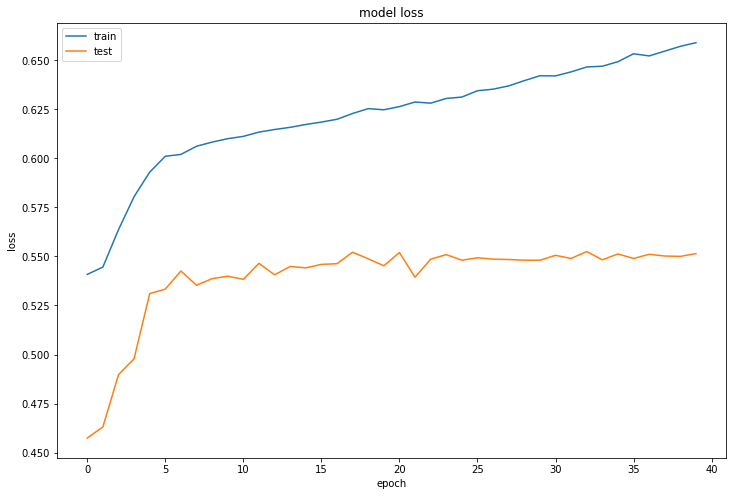

In [191]:
plt.figure(figsize=(12,8))
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [192]:
def predict_sample(sample):
    test_data = nltk.tokenize.sent_tokenize(sample)
    test_data = remove_symbols(test_data)
    test_svd = vectorizer.transform(test_data)
    test_svd = svd.transform(test_svd)
    return test_svd

In [202]:
sample = 'Damn that'
for_pred = predict_sample(sample)
inp = model.predict(for_pred.reshape(for_pred.shape[0], for_pred.shape[1], 1))

In [203]:
inp.shape

(1, 3)

In [196]:
def labelling(target):
    for_checking = []
    for sample in target:
        for_checking.append(np.argmax(sample))
    return for_checking
        

In [199]:
pred = model.predict(X_test_CNN)

In [197]:
test_check = labelling(y_test_CNN)

In [200]:
pred_check = labelling(pred)

In [201]:
print('Accuracy = ', accuracy_score(test_check, pred_check))
print('Recall = ', recall_score(test_check, pred_check, average='macro'))
print('Precision = ', precision_score(test_check, pred_check, average='macro'))
print('F1 = ', f1_score(test_check, pred_check, average='macro'))

Accuracy =  0.5514731984380546
Recall =  0.47796125635309306
Precision =  0.5638672161668347
F1 =  0.47616673060790937
